# ITALY REGIONS OVERVIEW

Other plots on this website:

- [Italy (nation)](covid-italy.html)
- [Italy (regions overview)](covid-italy-regions.html)
- [Italy (regions single)](covid-italy-regions-single.html)
- [Italy (province overview)](covid-italy-province.html)


- [ALL COUNTRIES (S)IRD](covid-countries-all.html)
- [Best 20 countries (overview)](covid-countries-overview.html)
- [Best 20 countries (single)](covid-countries.html)


- [Continents (overview)](covid-continents-overview.html)
- [Continents (single)](covid-continents.html)

Also on this website:
- [Italy & World map](index.php)
- [World real time data and map](covid-arcgis.php)

## Click on a region to remove
## Double-click on a region to isolate

Data repository: [link](https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json)

Jupyter Notebook repository: [link](https://github.com/maxdevblock/covid-19-jupyter)

[REGIONS DATA TABLE](regioni-tabella.html)

In [1]:
import json
import requests
import datetime as dt

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import numpy as np
import plotly.graph_objects as go
import plotly.offline as pyo

from scipy import stats as sps
from scipy.interpolate import interp1d
import pandas as pd

from IPython.display import clear_output

pyo.init_notebook_mode()
%matplotlib inline

# R<sub>t</sub>

Italy regions $R_t$ (effective reproduction number in time $t$) calculated with Bayesian approach ([Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) and [Kevin Systrom 2020](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb)).

([read here for details](https://maxpierini.it/R0.pdf))

In [2]:
defined_p = [.95, .5]

In [3]:
np.seterr(all='ignore')

states = None
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
states = pd.read_csv(url,
                     usecols=['data', 'denominazione_regione', 'totale_casi'],
                     parse_dates=['data'],
                     index_col=['denominazione_regione', 'data'],
                     squeeze=True).sort_index()

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7.5

def prepare_cases(cases, cutoff=1, win=7, std=2):

    new_cases = cases.diff()
    new_cases[new_cases < 0] = 1e-10

    smoothed = new_cases.rolling(win,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=std).round()
    smoothed[smoothed < 0] = 0
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = np.array([]), np.array([])
    j = 0
    while not lows.size or not highs.size:
        lows, highs = (total_p > (p-j)).nonzero()
        j += .05
        if j > 1:
            break
    
    if not len(lows):
        print("no lo")
        print(pmf)
        print(total_p)
        lows = np.array([0])
    if not len(highs):
        print("no hi")
        highs = np.array([1])
    
    try:
        # Find the smallest range (highest density)
        best = (highs - lows).argmin()
    except Exception as e:
        print("ERR {}".format(e))
        best = 0
    
    try:
        low = pmf.index[lows[best]]
    except Exception as err:
        print(f"lo{p} ERROR: {err}")
        low = 0
    try:
        high = pmf.index[highs[best]]
    except Exception as err:
        print(f"hi{p} ERROR: {err}")
        high = 1
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

def HDI_of_grid(probMassVec, credMass=0.95):
    sortedProbMass = np.sort(probMassVec, axis=None)[::-1]
    HDIheightIdx = np.min(np.where(np.cumsum(sortedProbMass) >= credMass))
    HDIheight = sortedProbMass[HDIheightIdx]
    HDImass = np.sum(probMassVec[probMassVec >= HDIheight])
    idx = np.where(probMassVec >= HDIheight)[0]
    return {'indexes':idx, 'mass':HDImass, 'height':HDIheight}


def HDI_of_grid_from_df(pmf, p):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([HDI_of_grid_from_df(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    res = HDI_of_grid(pmf, p)
    #print(res["indexes"])
    lo_idx = res["indexes"][0]
    hi_idx = res["indexes"][-1]
    
    lo = pmf.index[lo_idx]
    hi = pmf.index[hi_idx]
    
    return pd.Series([lo, hi],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])


def HDIs(pmf, P=[.95, .5]):
    RES = []
    for p in P:
        res = HDI_of_grid_from_df(pmf, p=p)
        RES.append(res)
    return RES

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    likelihoods[likelihoods==0] = 1e-15
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        #p_err = np.seterr(all='raise')
        #try:
        #    log_likelihood += np.log(denominator)
        #except Exception as err:
        #    print(f"log err {err} (d={denominator})")
        #    log_likelihood += np.log(1+1e-10)
        #np.seterr(**p_err)
    
    return posteriors, log_likelihood

# targets = ~states.index.get_level_values('denominazione_regione')
# states_to_process = states.loc[states]

#_results = {}

########################### SIGMAS ###########################
sigmas = np.linspace(1/20, 1, 20)

#for state_name, cases in states.groupby(level='denominazione_regione'):
#    print(f"log likelihoods for {state_name}...")
#    smoothed = []
#    cutoff = 20
#    while not len(smoothed):
#        new, smoothed = prepare_cases(cases, cutoff=cutoff)
#        cutoff -= 1
#    
#    result = {}
#    
#    # Holds all posteriors with every given value of sigma
#    result['posteriors'] = []
#    
#    # Holds the log likelihood across all k for each value of sigma
#    result['log_likelihoods'] = []
#    
#    for sigma in sigmas:
#        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
#        result['posteriors'].append(posteriors)
#        result['log_likelihoods'].append(log_likelihood)
#    
#    # Store all results keyed off of state name
#    _results[state_name] = result
#    #clear_output(wait=True)

########################### SIGMAS ###########################

sigma = .25

results = None

for name, cases in states.groupby(level='denominazione_regione'):
    #print(f"Rt {name}...")
    original, smoothed = prepare_cases(cases[cases>10])
    #if name == "Sardegna":
    #    print(original.tail(10))
    #    print(smoothed.tail(10))
    #    plt.plot(original.values, ls=":", c="k")
    #    plt.plot(smoothed.values, ls="-", c="r")

    #sigmas = np.linspace(1/20, 1, 20)
    
    ## Each index of this array holds the total of the log likelihoods for
    ## the corresponding index of the sigmas array.
    #total_log_likelihoods = np.zeros_like(sigmas)
    #
    ## Loop through each state's results and add the log likelihoods to the running total.
    #for state_name, result in results.items():
    #total_log_likelihoods += _results[name]['log_likelihoods']
    #
    ## Select the index with the largest log likelihood total
    #max_likelihood_index = total_log_likelihoods.argmax()
    #
    ## Select the value that has the highest log likelihood
    #sigma = sigmas[max_likelihood_index]
    #print(f"sigma = {sigma}")
    
    # Note that we're fixing sigma to a value just for the example
    posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)

    # Note that this takes a while to execute - it's not the most efficient algorithm
    #hdis = highest_density_interval(posteriors, p=defined_p)
    HDIS = HDIs(posteriors, P=defined_p)

    most_likely = posteriors.idxmax().rename('ML')

    # Look into why you shift -1
    result = most_likely
    for hdis in HDIS:
        result = pd.concat([result, hdis], axis=1)

    results = pd.concat([results, result])

#clear_output()

In [4]:
results.to_pickle("Rt-regions-time-series.pkl")

In [5]:
def plot_rt(result, ax, state_name, P=[.95, .5]):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,.75,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('data')
    values = result['ML'].values
    update = results.index.get_level_values('data')[-1].date()
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=20,
               lw=.25,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    extended = pd.date_range(start=pd.Timestamp('2020-02-24'),
                         end=index[-1]+pd.Timedelta(days=1))
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    for j, p in enumerate(P):
        lowfn = interp1d(date2num(index),
                         result[f'Low_{p*100:.0f}'].values,
                         bounds_error=False,
                         fill_value='extrapolate')

        highfn = interp1d(date2num(index),
                          result[f'High_{p*100:.0f}'].values,
                          bounds_error=False,
                          fill_value='extrapolate')



        ax.fill_between(extended,
                        lowfn(date2num(extended)),
                        highfn(date2num(extended)),
                        color='k',
                        alpha=.1*(j+1),
                        lw=0,
                        zorder=3+j)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-02-24'), result.index.get_level_values('data')[-1]+pd.Timedelta(days=1))
    plt.suptitle(
        f"Italian Regions Real Time $R_t$ up to {update} (HDI {','.join([f'{p:.0%}' for p in sorted(P)])})", 
        fontsize=30, y=1.02)
    fig.set_facecolor('w')
    return values[-1]

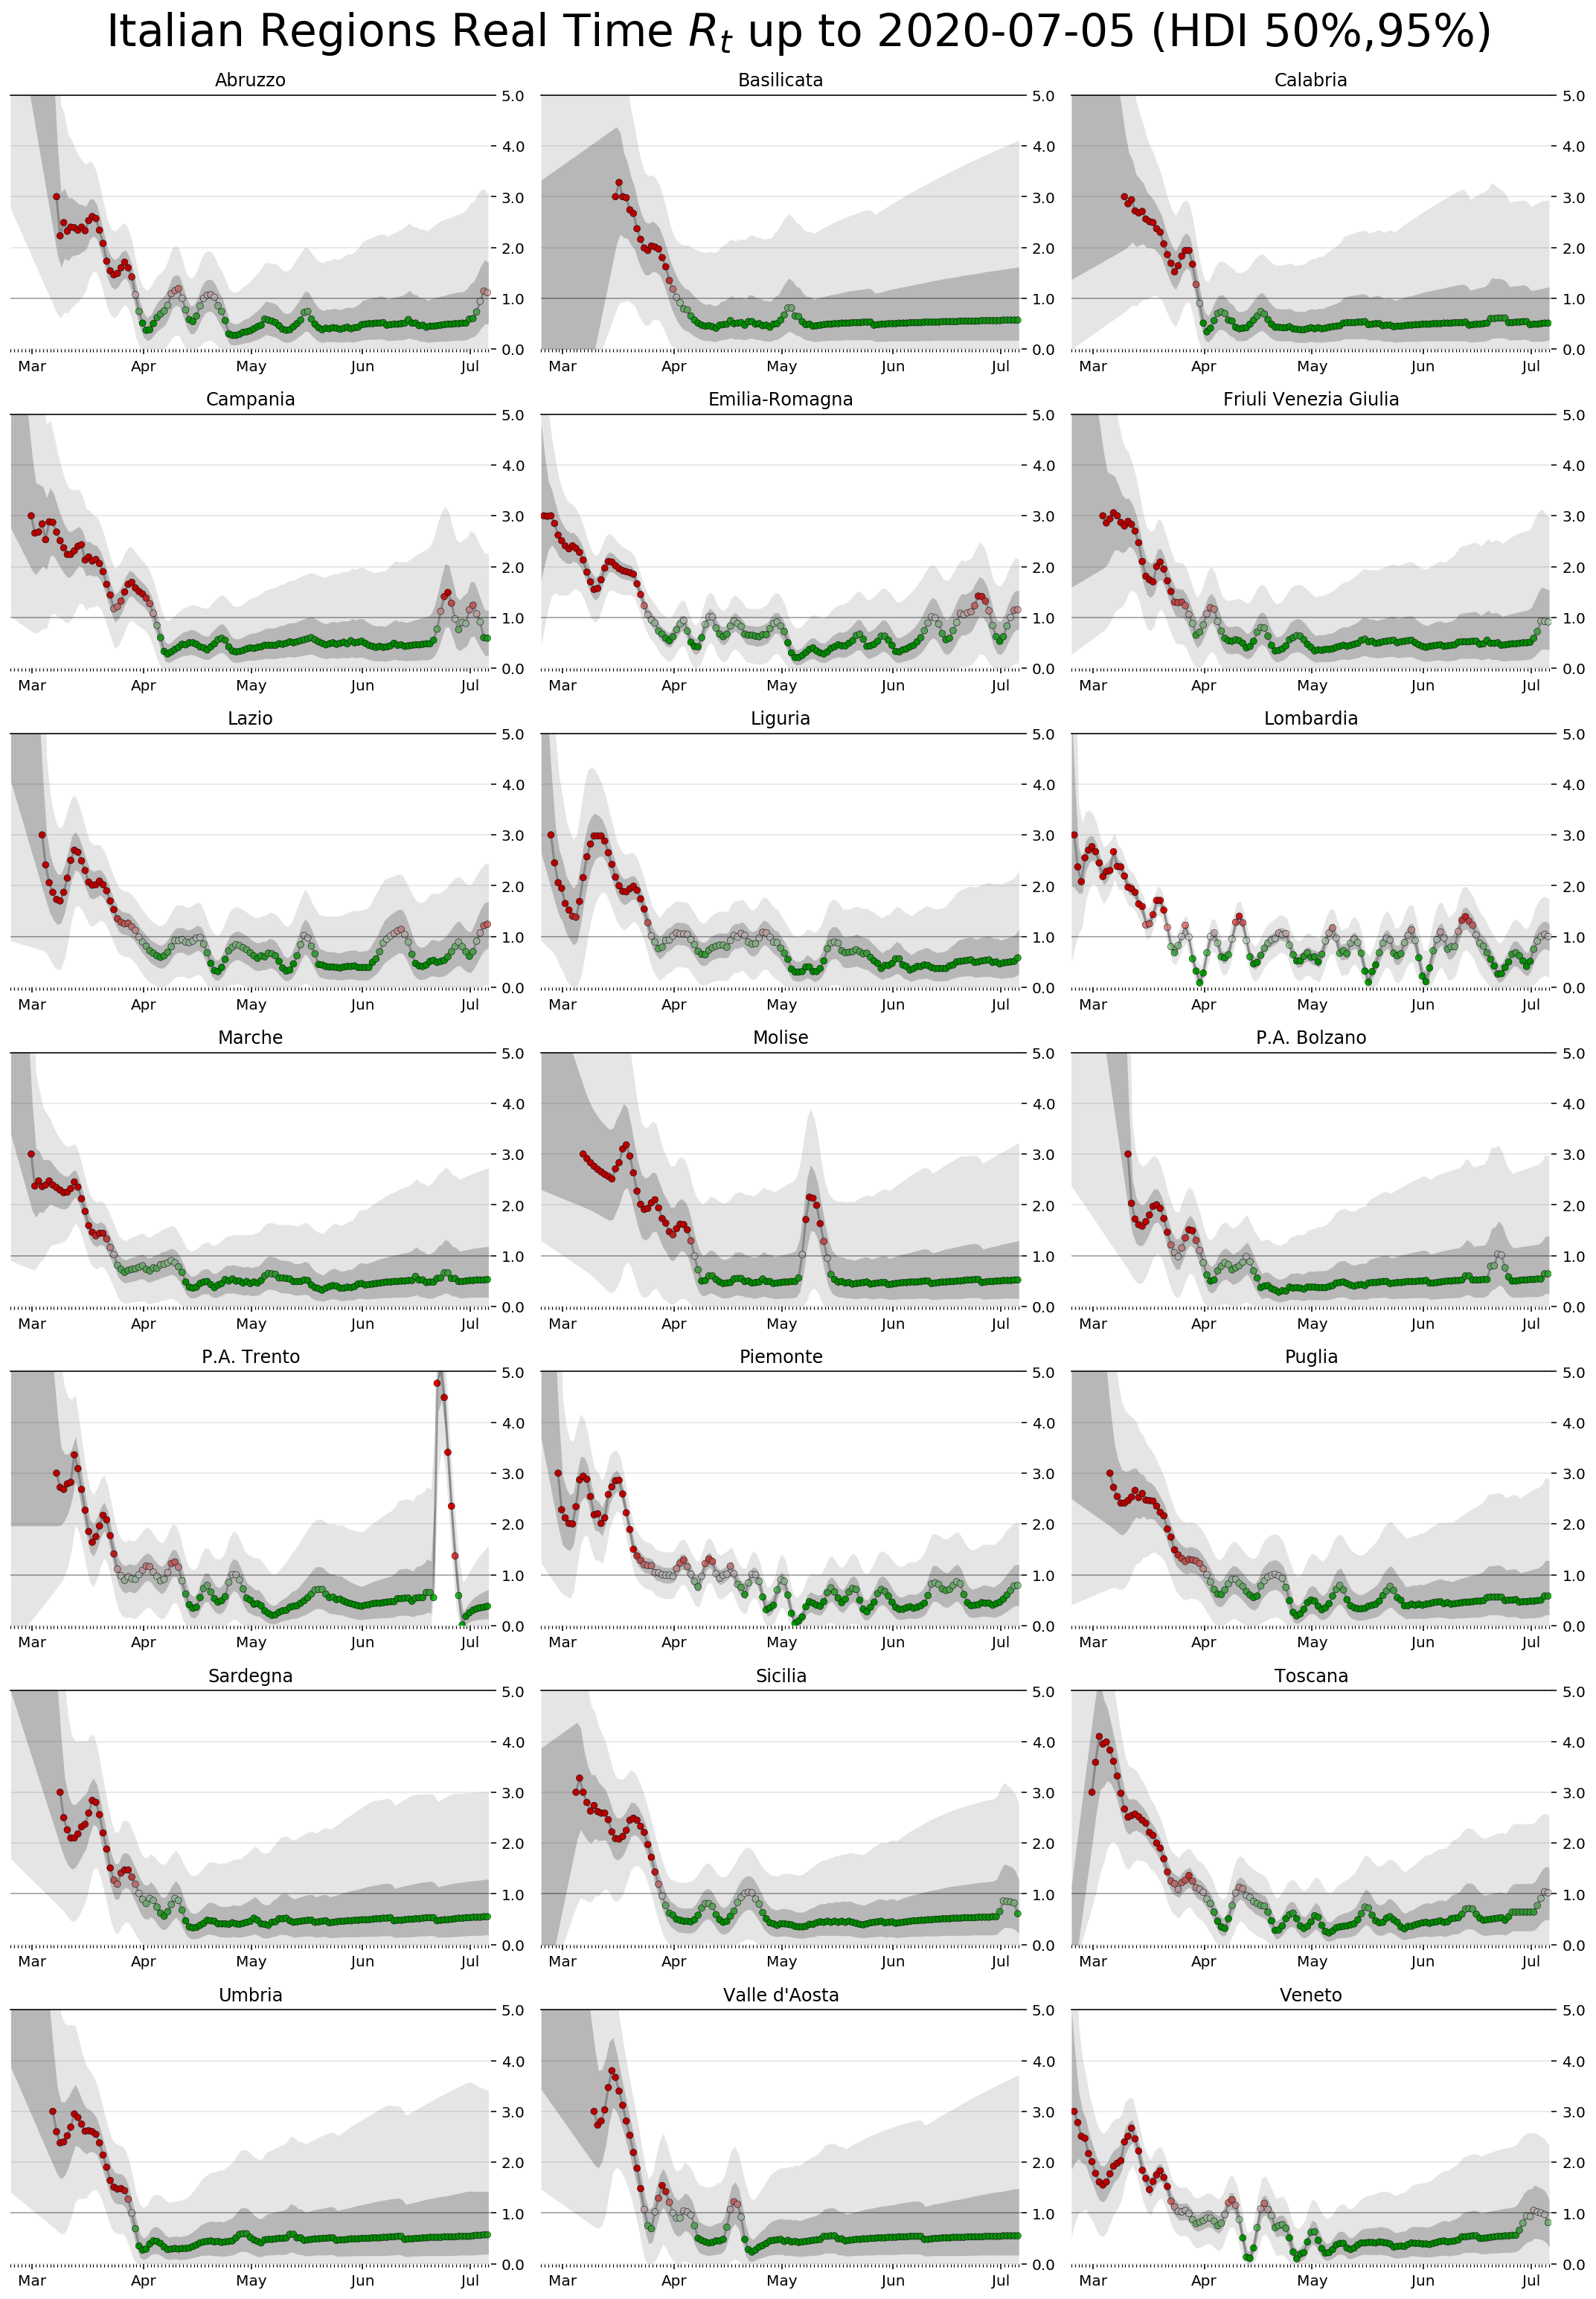

In [6]:
_R0 = {}
ncols = 3
nrows = 7

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(results.groupby('denominazione_regione')):
    last_Rt = plot_rt(result, axes.flat[i], state_name, P=defined_p)
    _R0.update({state_name: last_Rt})

fig.tight_layout()
fig.set_facecolor('w')

with open("R0_regioni.json", "w") as f:
    json.dump(_R0, f)

                          ML  High_50  Low_50
denominazione_regione                        
Abruzzo                1.125    1.745   0.495
Basilicata             0.570    1.605   0.170
Calabria               0.510    1.210   0.165
Campania               0.595    1.140   0.250
Emilia-Romagna         1.145    1.525   0.750
Friuli Venezia Giulia  0.915    1.560   0.370
Lazio                  1.225    1.670   0.745
Liguria                0.545    1.060   0.220
Lombardia              1.020    1.290   0.750
Marche                 0.525    1.175   0.180
Molise                 0.520    1.280   0.160
P.A. Bolzano           0.640    1.380   0.250
P.A. Trento            0.370    0.685   0.130
Piemonte               0.785    1.200   0.390
Puglia                 0.580    1.280   0.210
Sardegna               0.550    1.285   0.190
Sicilia                0.715    1.420   0.280
Toscana                1.030    1.535   0.495
Umbria                 0.570    1.425   0.190
Valle d'Aosta          0.550    1.

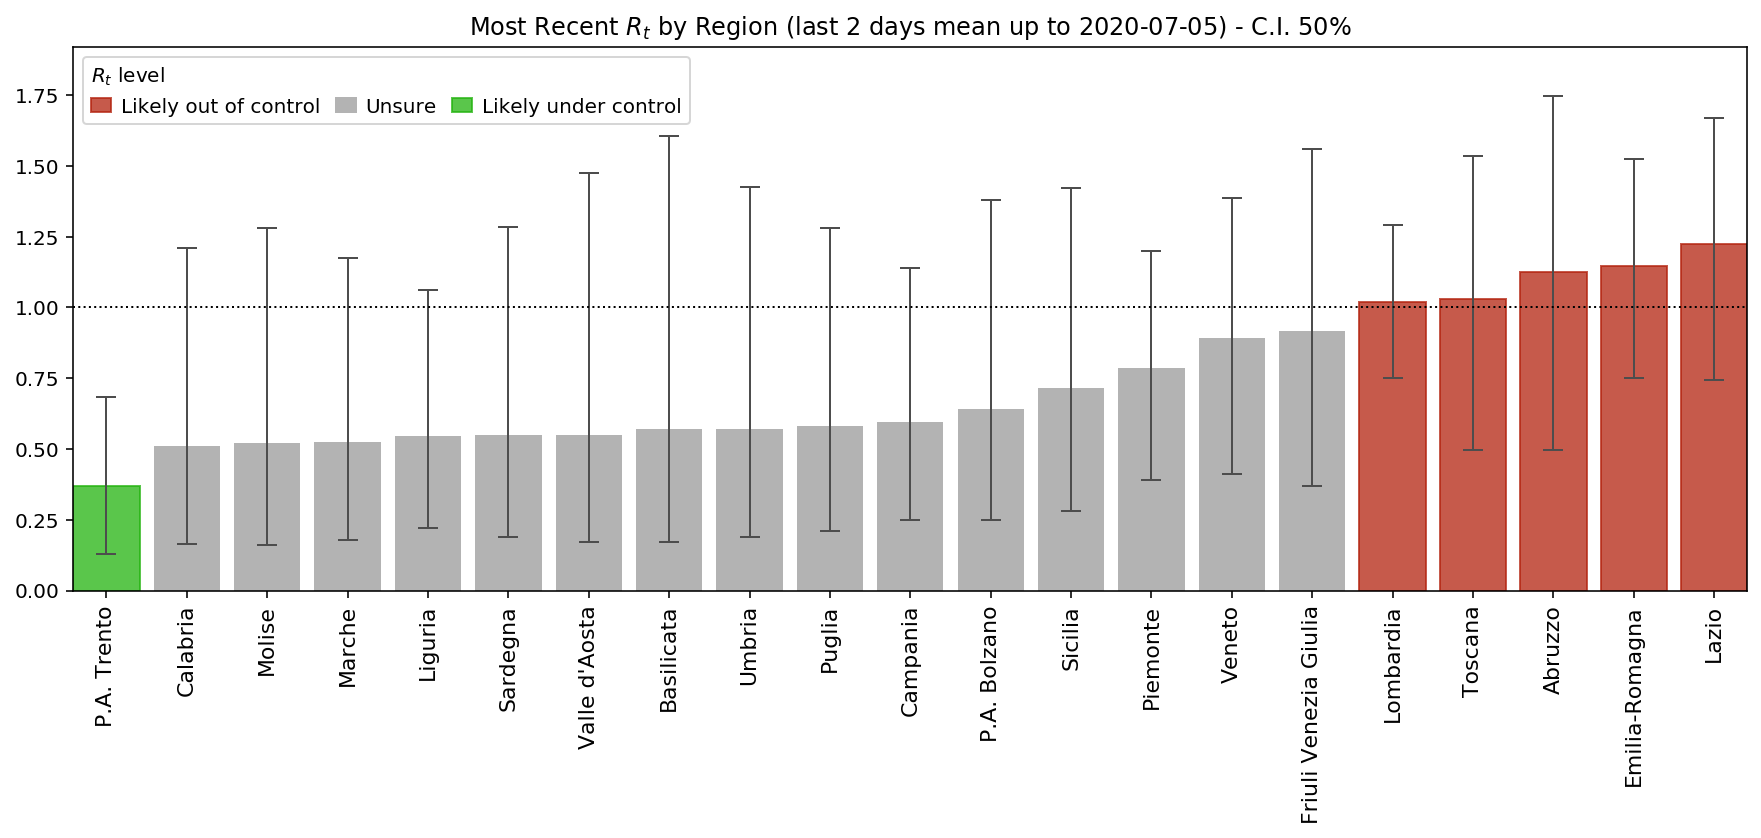

In [11]:
BO_COLOR = [.7,.7,.7]
NO_COLOR = [179/255,35/255,14/255,.75]
OK_COLOR = [.5,.5,.5]
KO_COLOR = [35/255,179/255,14/255,.75]
ERROR_BAR_COLOR = [.3,.3,.3]

def plot_standings(mr, figsize=None, p=.9, days=2):
    mr = results.groupby(level=0)[['ML', f'High_{p*100:.0f}', f'Low_{p*100:.0f}']].tail(days)
    mr = mr.groupby("denominazione_regione")[['ML', f'High_{p*100:.0f}', f'Low_{p*100:.0f}']].mean()
    print(mr)
    mr.sort_values('ML', inplace=True)
    update = results.index.get_level_values('data')[-1].date()
    
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(f'Most Recent $R_t$ by Region (last {days} days mean up to {update}) - C.I. {p:.0%}')
    
    err = mr[[f'Low_{p*100:.0f}', f'High_{p*100:.0f}']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=BO_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=5,
                  error_kw={'alpha':1, 'lw':1},
                  yerr=err.values.T)

    for bar, ml, h90 in zip(bars, mr["ML"], mr[f"High_{p*100:.0f}"]):
        if ml > 1:
            bar.set_color(NO_COLOR)
        #if ml < .75:
        #    bar.set_color(OK_COLOR)
        if h90 < 1:
            bar.set_color(KO_COLOR)

    labels = mr.index.to_series()  #.replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,max(mr[f"High_{p*100:.0f}"])*1.1)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Likely out of control', color=NO_COLOR),
                        Patch(label='Unsure', color=BO_COLOR),
                        #Patch(label='Near 0', color=OK_COLOR),
                        Patch(label='Likely under control', color=KO_COLOR)
                    ],
                    title='$R_t$ level',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

plot_standings(results, figsize=(15,5), p=min(defined_p));

In [7]:
json_regions = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json"
with requests.get(json_regions) as req:
    data = json.loads(req.content.decode('utf-8-sig'))

In [8]:
print("FIRST ENTRY DATE: {}".format(
    data[0]["data"]
    )
)
print("LAST  ENTRY DATE: {}".format(
    data[-1]["data"]
    )
)
period = (
    dt.datetime.strptime(data[-1]["data"], "%Y-%m-%dT%H:%M:%S") -
    dt.datetime.strptime(data[0]["data"], "%Y-%m-%dT%H:%M:%S")
).days

print("COVERAGE: {} days".format(period))
print("CURRENT DATE IS: {}".format(dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

FIRST ENTRY DATE: 2020-02-24T18:00:00
LAST  ENTRY DATE: 2020-05-14T17:00:00
COVERAGE: 79 days
CURRENT DATE IS: 2020-05-15 14:19:38


In [9]:
x = []   # datetime x array
# _x = []  # integer x array
# yC = []  # new confirmed cases array
# yD = []  # new deaths array
# yR = []  # new recovered array
# yP = []  # new infected array

TOTyC = {}  # confirmed cases array
TOTyD = {}  # deaths array
TOTyR = {}  # recovered array
TOTyP = {}  # infected array
TOTyr = {}  # mortality rate
TOTyk = {}  # recovery rate

TOTyPric = {}  # ricoverati
TOTyPint = {}  # intensiva
TOTyPiso = {}  # isolamento

In [10]:
for entry in data:

    # x values
    date = dt.datetime.strptime(entry["data"], "%Y-%m-%dT%H:%M:%S")
    if date not in x:
        x.append(date)
        
    region = entry["denominazione_regione"]
    if region not in TOTyC:
        TOTyC.update({region: np.array([])})
        TOTyD.update({region: np.array([])})
        TOTyR.update({region: np.array([])})
        TOTyP.update({region: np.array([])})
        TOTyr.update({region: np.array([])})
        TOTyk.update({region: np.array([])})
        TOTyPric.update({region: np.array([])})
        TOTyPint.update({region: np.array([])})
        TOTyPiso.update({region: np.array([])})
    # y TOT values
    TOTyC[region] = np.append(TOTyC[region], entry["totale_casi"])
    TOTyD[region] = np.append(TOTyD[region], entry["deceduti"])
    TOTyR[region] = np.append(TOTyR[region], int(entry["dimessi_guariti"]))
    TOTyP[region] = np.append(TOTyP[region], entry["totale_positivi"])
    TOTyPric[region] = np.append(TOTyPric[region], entry["ricoverati_con_sintomi"])
    TOTyPint[region] = np.append(TOTyPint[region], entry["terapia_intensiva"])
    TOTyPiso[region] = np.append(TOTyPiso[region], entry["isolamento_domiciliare"])
    
    if entry["totale_casi"]:
        TOTyr[region] = np.append(TOTyr[region], entry["deceduti"] / entry["totale_casi"])
        TOTyk[region] = np.append(TOTyk[region],
                                  (int(entry["dimessi_guariti"])) / 
                                  entry["totale_casi"])
    else:
        TOTyr[region] = np.append(TOTyr[region], .0)
        TOTyk[region] = np.append(TOTyk[region], .0)

_C = [TOTyC[r][0] for r in TOTyC]
minC = max(_C)
_D = [TOTyD[r][0] for r in TOTyD]
minD = max(_D)
_R = [TOTyR[r][0] for r in TOTyR]
minR = max(_R)
_P = [TOTyP[r][0] for r in TOTyP]
minP = max(_P)

_ric = [TOTyPric[r][0] for r in TOTyPric]
minric = min(_ric)
_int = [TOTyPint[r][0] for r in TOTyPint]
minint = min(_int)
_iso = [TOTyPiso[r][0] for r in TOTyPiso]
miniso = min(_iso)

## TOTAL CASES

In [11]:
fig = go.Figure()

for region in TOTyC:
    fig.add_trace(go.Scatter(
        x=x, y=TOTyC[region],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(len(x))]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (cases)", "xanchor": "center", "x": 0.5},
    yaxis_title="cases",
)

pyo.iplot(fig)

In [12]:
fig = go.Figure()

for region in TOTyC:
    fig.add_trace(go.Scatter(
        x=x, y=TOTyC[region],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(len(x))]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (cases, log scale)", "xanchor": "center", "x": 0.5},
    yaxis_title="cases", yaxis_type="log",
)

pyo.iplot(fig)

<hr>

## DEATHS

In [13]:
fig = go.Figure()

for region in TOTyD:
    fig.add_trace(go.Scatter(
        x=x, y=TOTyD[region],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(len(x))]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (deaths)", "xanchor": "center", "x": 0.5},
    yaxis_title="deaths",
)

pyo.iplot(fig)

In [14]:
fig = go.Figure()

for region in TOTyD:
    fig.add_trace(go.Scatter(
        x=x, y=TOTyD[region],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(len(x))]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (deaths, log scale)", "xanchor": "center", "x": 0.5},
    yaxis_title="deaths", yaxis_type="log",
)

pyo.iplot(fig)

<hr>

## RECOVERED

In [15]:
fig = go.Figure()

for region in TOTyR:
    fig.add_trace(go.Scatter(
        x=x, y=TOTyR[region],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(len(x))]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (recovered)", "xanchor": "center", "x": 0.5},
    yaxis_title="recovered",
)

pyo.iplot(fig)

In [16]:
fig = go.Figure()

for region in TOTyR:
    fig.add_trace(go.Scatter(
        x=x, y=TOTyR[region],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(len(x))]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (recovered, log scale)", "xanchor": "center", "x": 0.5},
    yaxis_title="recovered",  yaxis_type="log",
)

pyo.iplot(fig)

<hr>

## INFECTED

In [17]:
fig = go.Figure()

for region in TOTyP:
    fig.add_trace(go.Scatter(
        x=x, y=TOTyP[region],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(len(x))]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (infected)", "xanchor": "center", "x": 0.5},
    yaxis_title="infected",
)

pyo.iplot(fig)

In [18]:
fig = go.Figure()

for region in TOTyP:
    fig.add_trace(go.Scatter(
        x=x, y=TOTyP[region],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(len(x))]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (infected, log scale)", "xanchor": "center", "x": 0.5},
    yaxis_title="infected",  yaxis_type="log",
)

pyo.iplot(fig)

<hr>

## MORTALITY RATE

!!! PLEASE NOTE !!!

These rates are only useful for **SIRD** epidemiological model ([read here for details](https://maxpierini.it/R0.pdf)) not to define COVID-19 actual rates.

In [19]:
fig = go.Figure()

for region in TOTyr:
    fig.add_trace(go.Scatter(
        x=x, y=TOTyr[region],
        mode='lines+markers',
        marker_size=3, marker_symbol="cross",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.2%}",
        text=[region for _ in range(len(x))]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696', "tickformat": ',.0%',},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (mortality rate)", "xanchor": "center", "x": 0.5},
    yaxis_title="percentage",
)

pyo.iplot(fig)

## RECOVERY RATE

In [20]:
fig = go.Figure()

for region in TOTyk:
    fig.add_trace(go.Scatter(
        x=x, y=TOTyk[region],
        mode='lines+markers',
        marker_size=3, marker_symbol="cross",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.2%}",
        text=[region for _ in range(len(x))]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696', "tickformat": ',.0%',},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (recovery rate)", "xanchor": "center", "x": 0.5},
    yaxis_title="percentage",
)

pyo.iplot(fig)

## OSPITALIZED DETAILS

In [21]:
fig = go.Figure()

for region in TOTyPric:
    fig.add_trace(go.Scatter(
        x=x, y=TOTyPric[region],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(len(x))]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (symptomatic hospitalized)", "xanchor": "center", "x": 0.5},
    yaxis_title="number",
)

pyo.iplot(fig)

In [22]:
fig = go.Figure()

for region in TOTyPint:
    fig.add_trace(go.Scatter(
        x=x, y=TOTyPint[region],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(len(x))]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (in emergency)", "xanchor": "center", "x": 0.5},
    yaxis_title="number",
)

pyo.iplot(fig)

In [23]:
fig = go.Figure()

for region in TOTyPiso:
    fig.add_trace(go.Scatter(
        x=x, y=TOTyPiso[region],
        mode='lines+markers',
        marker_size=3, marker_symbol="circle",
        line_shape='spline',
        name=region,
        hovertemplate="%{text}"+
        "<br>%{x}"+
        "<br>%{y:.0f}",
        text=[region for _ in range(len(x))]
    ))

fig.update_layout(legend_orientation="h",
    showlegend=True, plot_bgcolor='rgba(0,0,0,0)', 
    yaxis={"gridcolor": '#bdbdbd', "zerolinecolor": '#969696'},
    xaxis={"gridcolor": '#bdbdbd'},
    title={"text": "ITALY regions (home isolated)", "xanchor": "center", "x": 0.5},
    yaxis_title="number",
)

pyo.iplot(fig)